# Initialization stuff

In [1]:
using CMBLensing
using CMBLensing: δlnP_δfϕₜ, δfϕ_δf̃ϕ
using Optim
using PyPlot

In [2]:
using PyCall
@pyimport seaborn as sns
sns.set_context("notebook",font_scale=1.2,rc=Dict("lines.markeredgewidth"=>1))

In [3]:
## calc Cℓs and store in Main since I reload CMBLensing alot during development
cls = isdefined(Main,:cls) ? Main.cls : @eval Main cls=$(class(lmax=8000,r=0.05));

In [25]:
## set up the types of maps
Θpix, nside, T = 3, 1024, Float32
P = Flat{Θpix,nside}
## covariances
Cf = Cℓ_to_cov(T,P,S2,cls[:ℓ], cls[:ee],    cls[:bb])
Cf̃ = Cℓ_to_cov(T,P,S2,cls[:ℓ], cls[:ln_ee], cls[:ln_bb])
Cϕ = Cℓ_to_cov(T,P,S0,cls[:ℓ], cls[:ϕϕ])
μKarcminT = 1
Ωpix = deg2rad(Θpix/60)^2
# CN = CN̂ = Cℓ_to_cov(T,P,S2,cls[:ℓ], repeated(1e-2*cls[:bb],2)...)
CN = FullDiagOp(FlatS2QUMap{T,P}(repeated(fill(μKarcminT^2 * Ωpix,(nside,nside)),2)...))
CN̂  = FullDiagOp(FlatS2EBFourier{T,P}(repeated(fill(μKarcminT^2 * Ωpix,(nside÷2+1,nside)),2)...))
##
f = simulate(Cf)
ϕ = simulate(Cϕ)
# L = PowerLensOrder{4}
L = LenseFlow{CMBLensing.ode4{5}}
f̃ = L(ϕ)*f

# data
ℓmax_mask, Δℓ_taper = 3000, 0
Ml = [ones(ℓmax_mask); (cos(linspace(0,π,Δℓ_taper))+1)/2]
Md = Cℓ_to_cov(T,P,S2,1:(ℓmax_mask+Δℓ_taper),repeated(Ml,2)...) * Squash

# field prior
# ℓmax_mask, Δℓ_taper = 3000, 0
# Ml = [ones(ℓmax_mask); (cos(linspace(0,π,Δℓ_taper))+1)/2]
# Mf = Cℓ_to_cov(T,P,S2,1:(ℓmax_mask+Δℓ_taper),repeated(Ml,2)...) * Squash
Ml = ones(Complex{T},nside÷2+1,nside)
i = indexin([-FFTgrid(T,P).nyq],FFTgrid(T,P).k)[1]
Ml[:,i]=Ml[i,:]=0
Mf = FullDiagOp(FlatS2EBFourier{T,P}(Ml,Ml)) * Squash

# ϕ  prior
Mϕ = Squash


ds = DataSet(f̃ + simulate(CN), CN, Cf, Cϕ, Md, Mf, Mϕ);
##

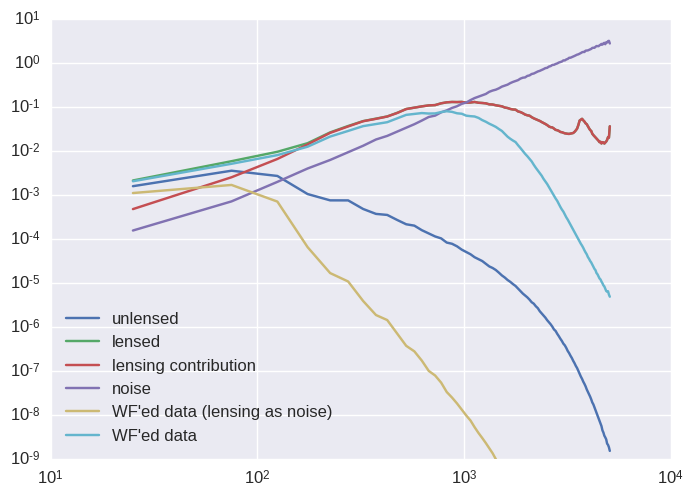

PyObject <matplotlib.legend.Legend object at 0x7fa53478dc90>

In [26]:
Δℓ=50
semilogy(get_Cℓ(f,which=[:BB],Δℓ=Δℓ)...,label="unlensed")
semilogy(get_Cℓ(f̃,which=[:BB],Δℓ=Δℓ)...,label="lensed")
# semilogy((@. cls[:ℓ]^2*cls[:ln_bb]/(2π)),"k--")
semilogy(get_Cℓ(f-f̃,which=[:BB],Δℓ=Δℓ)...,label="lensing contribution")
semilogy(get_Cℓ(simulate(CN),which=[:BB],Δℓ=Δℓ)...,label="noise""")
semilogy(get_Cℓ(𝕎(Cf,@. CN̂ + (Cf̃-Cf))*ds.d,which=[:BB],Δℓ=Δℓ)...,label="WF'ed data (lensing as noise)")
semilogy(get_Cℓ(𝕎(Cf̃,@. CN̂)*ds.d,which=[:BB],Δℓ=Δℓ)...,label="WF'ed data")

ylim(1e-9,1e1)
xscale("log")
legend(loc="lower left")

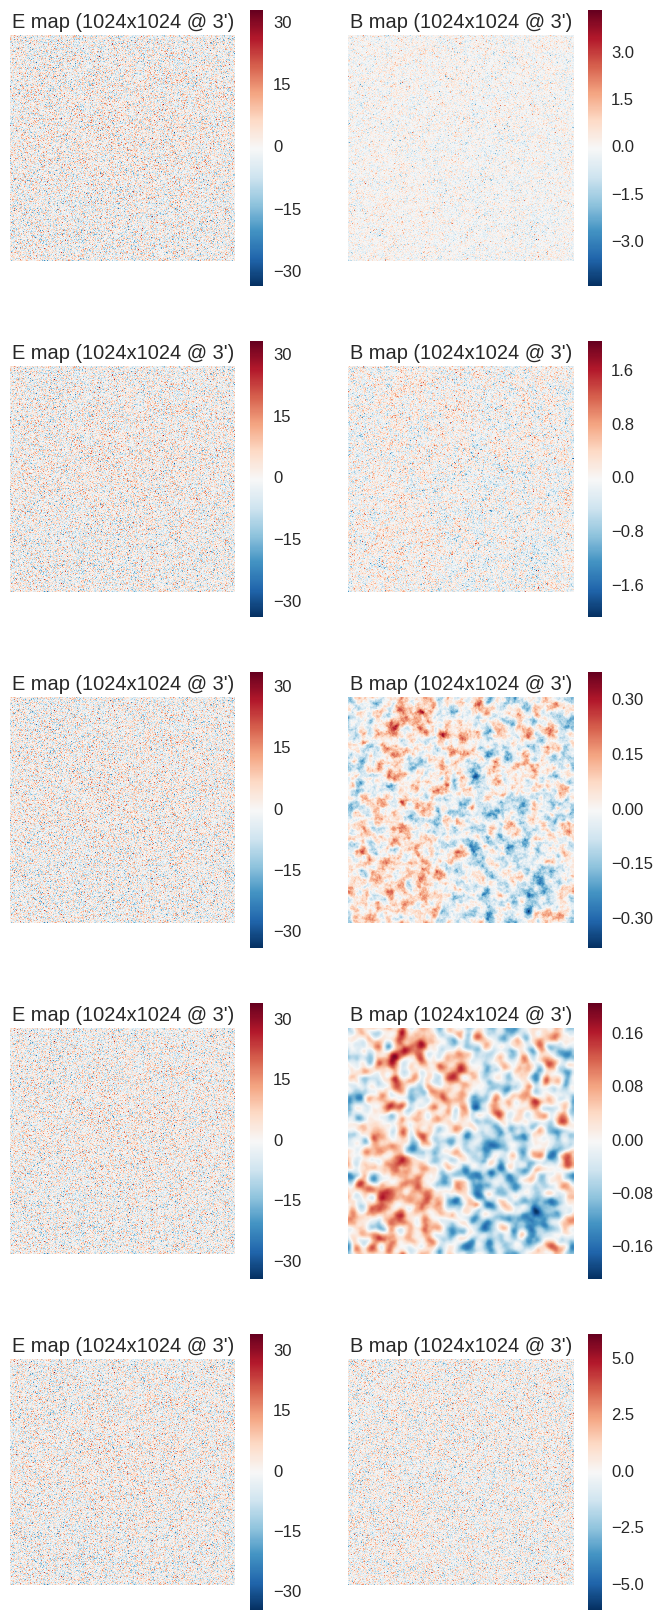

In [27]:
Mf.*[f̃, 𝕎(Cf̃,CN̂)*ds.d, f, 𝕎(Cf,@. CN̂ + (Cf̃-Cf))*ds.d, ds.d] |> plot

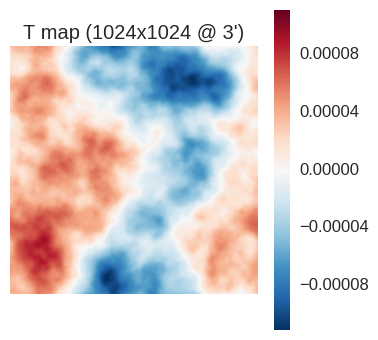

In [32]:
ϕ |> plot

In [33]:
fcur, ϕcur = fstart, ϕstart = f̃cur, ϕcur = f̃start, ϕstart = fϕstart = fϕcur = f̃ϕstart = f̃ϕcur = Ł(FieldTuple(Squash*𝕎(Cf̃,CN̂)*ds.d,0ϕ));

In [34]:
approxℍ⁻¹ = FullDiagOp(FieldTuple(Squash*(@. (Md.a*CN̂^-1 + Mf.a*Cf^-1)^-1).f, 1e-5*Mϕ*Cϕ.f));

In [35]:
ℕ⁻¹ = nan2zero.(FullDiagOp(FieldTuple(Md.a ./ CN̂.f, 0ds.Cϕ.f)))
𝕊⁻¹ = nan2zero.(FullDiagOp(FieldTuple(Mf.a ./ ds.Cf.f, 1 ./ ds.Cϕ.f)));
ℕ = nan2zero.(FullDiagOp(FieldTuple(Md.a .* CN̂.f, 0ds.Cϕ.f)))
𝕊 = nan2zero.(FullDiagOp(FieldTuple(Mf.a .* ds.Cf.f, ds.Cϕ.f)));

# $\chi^2$ targets

Here I calculate the number of unmasked DOF in the three likelihood terms:

In [36]:
ddof = (0Ð(f).+1)⋅(Md*(0Ð(f).+1)) / FFTgrid(T,P).Δℓ^2
fdof = (0Ð(f).+1)⋅(Mf*(0Ð(f).+1)) / FFTgrid(T,P).Δℓ^2
ϕdof = (0Ð(ϕ).+1)⋅(Mϕ*(0Ð(ϕ).+1)) / FFTgrid(T,P).Δℓ^2
ddof, fdof, ϕdof

(1.143864f6, 2.093058f6, 1.048576f6)

What the total χ² of the truth should be, compared to what it actually is:

In [37]:
(ddof+fdof+ϕdof)/2, -lnP(1,f̃,ϕ,ds)

(2.142749f6, 8.117929f6)

Given my "rule of thumb", here's where I think we need to get to (which is well below the truth, and indeed if you see below we get to there)

In [38]:
ddof/2

571932.0f0

# Some t=1 steps

In [39]:
using Parameters
include("/home/marius/workspace/baylens/scripts/cg.jl")
using NonlinConjGrad

In [44]:
import Base.LinAlg.A_ldiv_B!
hists = []
Hinvgs = []
mutable struct cg_ℍ⁻¹
    f̃cur
    ϕcur
end
function A_ldiv_B!(s,P::cg_ℍ⁻¹,q)
#     s.=Ł(approxℍ⁻¹*q[~f̃ϕcur])[:]
    f̃cur, ϕcur = P.f̃cur, P.ϕcur
    fcur = L(ϕcur)\f̃cur
    ℍ = let δfϕ_δf̃ϕ = δfϕ_δf̃ϕ(LenseFlow{CMBLensing.ode4{2}}(ϕcur),fcur,f̃cur)
        ℕ⁻¹ + δfϕ_δf̃ϕ' * (𝕊⁻¹ * δfϕ_δf̃ϕ)
    end
    Hinvg,hist = NonlinConjGrad.pcg(sqrt.(approxℍ⁻¹),ℍ,q[~f̃ϕcur]; nsteps=10)
    push!(hists,hist)
    push!(Hinvgs,Hinvg)
    s.=Ł(Hinvg)[:]
end

@time rescg = optimize(
    x->(-lnP(1,x[~f̃ϕstart]...,ds)),
    (x,∇f)->∇f .= -Ł(δlnP_δfϕₜ(1,x[~f̃ϕstart]...,ds))[:],
    f̃ϕcur[:],
    LBFGS(; 
        m = 1000,
        linesearch = LineSearches.hagerzhang!,
        P = cg_ℍ⁻¹(f̃ϕcur...),
        precondprep = (P, x) -> (P.f̃cur,P.ϕcur)=x[~f̃ϕstart]
    ),
    Optim.Options(iterations = 40, store_trace=true, show_trace=true)
)

Iter     Function value   Gradient norm 
     0     6.471479e+08     5.681121e+19
     1     2.156948e+08     1.796014e+20
     2     1.412783e+08     3.197266e+19
     3     1.080777e+08     6.886898e+19
     4     8.252942e+07     1.916331e+19
     5     6.155373e+07     1.789245e+19
     6     4.916509e+07     9.682592e+18
     7     4.077192e+07     1.146824e+19
     8     3.472346e+07     1.030762e+19
     9     2.951990e+07     4.631934e+18
    10     2.599439e+07     4.463375e+18
    11     2.287521e+07     4.422213e+18
    12     2.014949e+07     5.326878e+18
    13     1.803002e+07     5.235400e+18
    14     1.624161e+07     2.753844e+18
    15     1.462775e+07     3.582662e+18
    16     1.337623e+07     2.307880e+18
    17     1.222356e+07     2.244562e+18
    18     1.128510e+07     2.624829e+18
    19     1.047637e+07     2.606379e+18
    20     9.797337e+06     3.516986e+18
    21     9.183364e+06     3.073810e+18
    22     8.637506e+06     2.585100e+18
    23     8.142

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.22468556,-0.5275146, ...]
 * Minimizer: [0.7338383,-1.0525377, ...]
 * Minimum: 4.389252e+06
 * Iterations: 40
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * f(x) > f(x'): false
   * Reached Maximum Number of Iterations: true
 * Objective Function Calls: 146
 * Gradient Calls: 146

In [45]:
(f̃cur,ϕcur) = f̃ϕcur = Ł(rescg.minimizer[~f̃ϕstart])
fcur, ϕcur = fϕcur = Ł(FieldTuple(LenseFlow(ϕcur)\f̃cur, ϕcur));

This is a trace of the CG residual norm for the 20 CG runs that happened at each of the LBFGS steps above

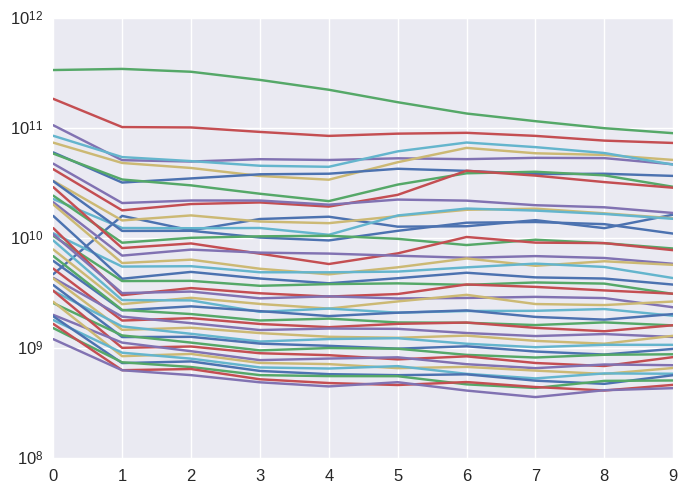

In [46]:
for (i,h)=enumerate(hists)
    semilogy(h)#,c=get_cmap("jet",length(rescg.trace))(i))
end

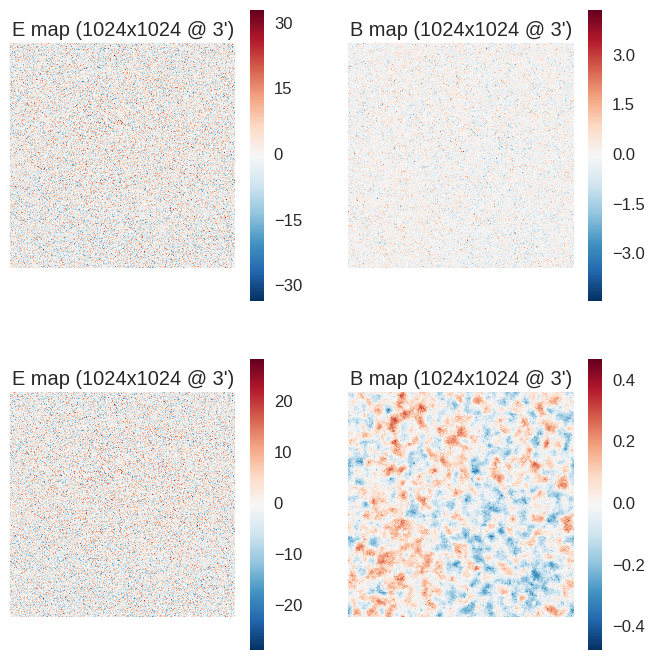

In [47]:
Mf.*[f̃,f̃cur] |> plot

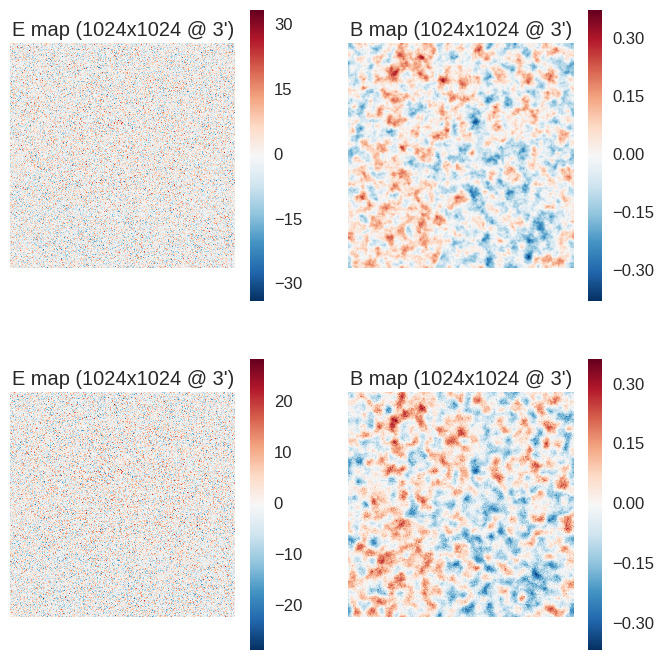

In [48]:
Mf.*[f,fcur] |> plot

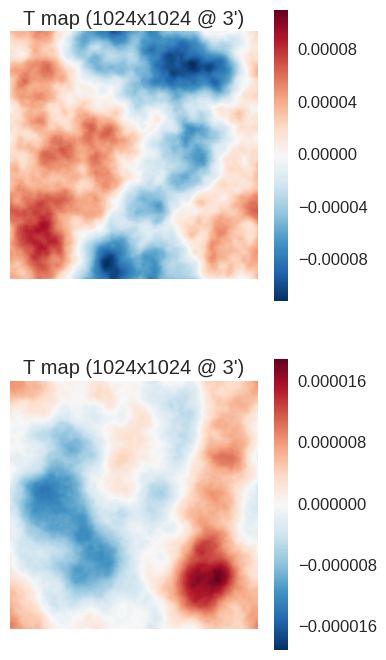

In [49]:
[ϕ,ϕcur] |> plot

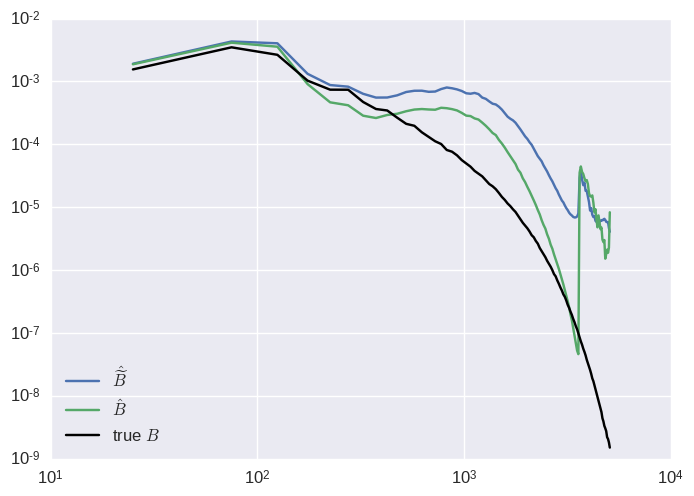

PyObject <matplotlib.legend.Legend object at 0x7fa52d2c9390>

In [50]:
loglog(get_Cℓ(f̃ϕcur[1],which=[:BB])..., label=raw"$\hat \widetilde B$")

loglog(get_Cℓ(fϕcur[1],which=[:BB])..., label=raw"$\hat B$")
semilogy(get_Cℓ(f,which=[:BB])...,c="k", label=raw"true $B$")
legend(loc="lower left")

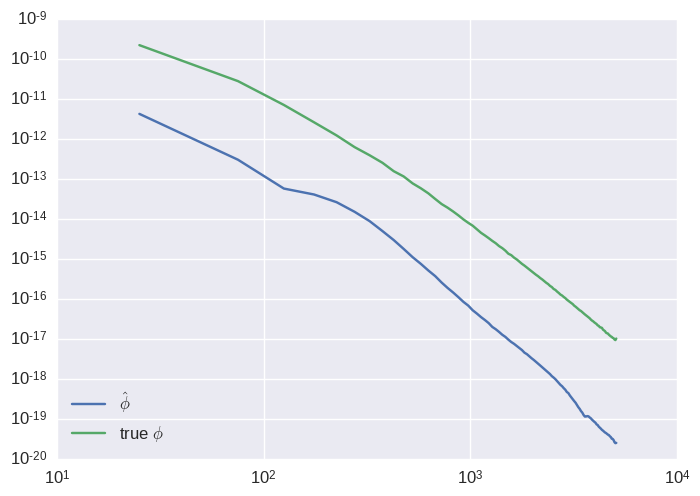

PyObject <matplotlib.legend.Legend object at 0x7fa5345c4a50>

In [51]:
loglog(get_Cℓ(fϕcur[2])...,label=raw"$\hat \phi$")
loglog(get_Cℓ(ϕ)..., label=raw"true $\phi$")
legend(loc="lower left")

# Some t=0 steps

In [53]:
import Base.LinAlg.A_ldiv_B!
hists0 = []
mutable struct cg_ℍ⁻¹
    f̃cur
    ϕcur
end
function A_ldiv_B!(s,P::cg_ℍ⁻¹,q)
    fcur, ϕcur = P.f̃cur, P.ϕcur
    f̃cur = L(ϕcur)*fcur
    ℍ = let δf̃ϕ_δfϕ = δf̃ϕ_δfϕ(LenseFlow{CMBLensing.ode4{2}}(ϕcur),f̃cur,fcur)
        δf̃ϕ_δfϕ' * (ℕ⁻¹ * δf̃ϕ_δfϕ) + 𝕊⁻¹
    end
    Hinvg,hist = NonlinConjGrad.pcg(sqrt.(approxℍ⁻¹),ℍ,q[~f̃ϕcur]; nsteps=100)
    push!(hists0,hist)
    s.=Ł(Hinvg)[:]
end

@time rescg0 = optimize(
    x->-lnP(0,x[~f̃ϕstart]...,ds,L),
    (x,∇f)->∇f .= -Ł(δlnP_δfϕₜ(0,x[~f̃ϕstart]...,ds,L))[:],
    fϕcur[:],
    LBFGS(; 
        m = 1000,
        linesearch = LineSearches.hagerzhang!,
        P = cg_ℍ⁻¹(fϕcur...),
        precondprep = (P, x) -> (P.f̃cur,P.ϕcur)=x[~f̃ϕstart]
    ),
    Optim.Options(iterations = 4, store_trace=true, show_trace=true)
)

Iter     Function value   Gradient norm 
     0     4.389250e+06     1.962885e+14
     1     7.521379e+05     1.314592e+14
     2     5.978184e+05     6.730335e+13
     3     5.861519e+05     5.495130e+13
     4     5.791185e+05     3.438231e+13
2608.988670 seconds (12.00 M allocations: 1.560 TiB, 66.21% gc time)


Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.3853997,-1.1751992, ...]
 * Minimizer: [-1.7717228,-2.4814553, ...]
 * Minimum: 5.791185e+05
 * Iterations: 4
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * f(x) > f(x'): false
   * Reached Maximum Number of Iterations: true
 * Objective Function Calls: 15
 * Gradient Calls: 15

In [54]:
(fcur,ϕcur) = fϕcur = Ł(rescg0.minimizer[~f̃ϕstart])
f̃cur, ϕcur = f̃ϕcur = Ł(FieldTuple(LenseFlow(ϕcur)*fcur, ϕcur));

In [55]:
lnP(0,fϕcur...,ds), lnP(1,f̃ϕcur...,ds)

(-579117.8f0, -579139.8f0)

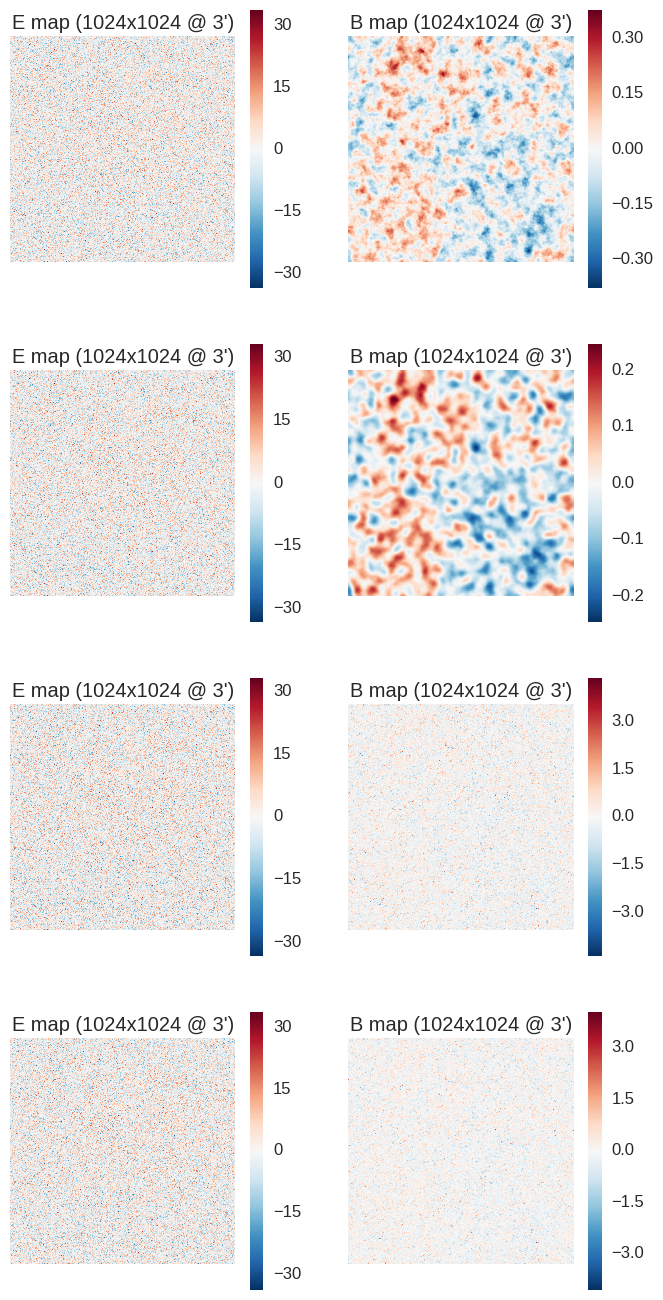

In [56]:
[Mf*f,Mf*fcur,Mf*f̃,Mf*f̃cur] |> plot

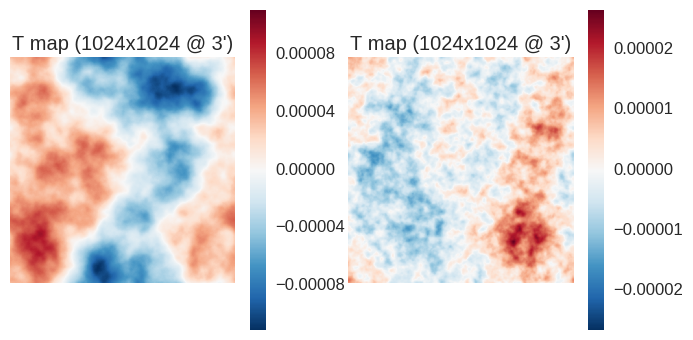

In [57]:
[ϕ,ϕcur]' |> plot

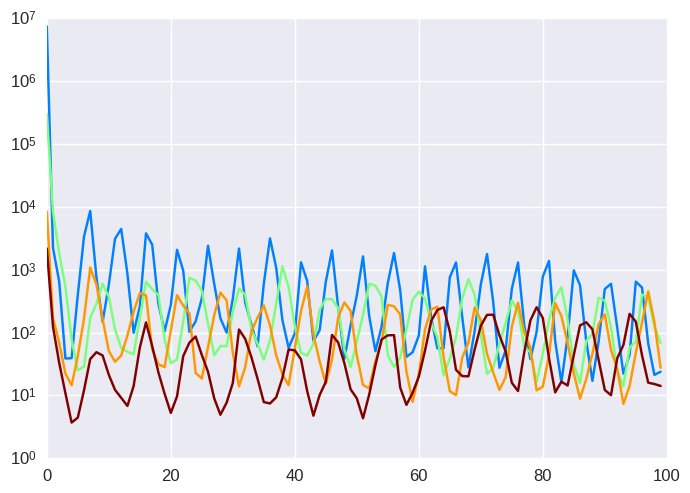

In [58]:
for (i,h)=enumerate(hists0)
    semilogy(h,c=get_cmap("jet",length(rescg0.trace))(i))
end

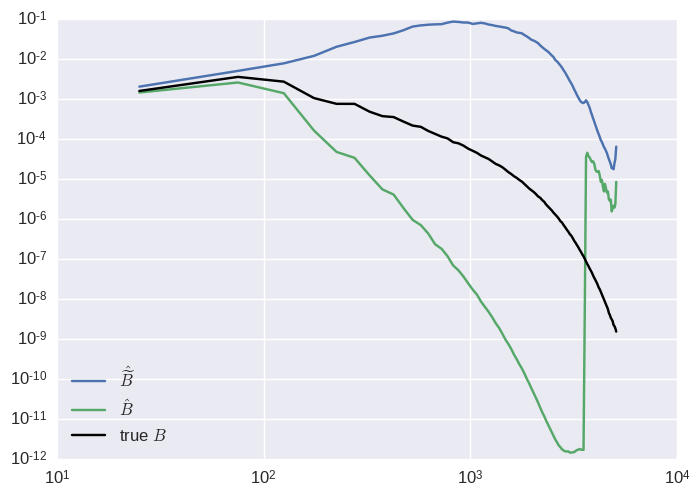

PyObject <matplotlib.legend.Legend object at 0x7fa52d675ed0>

In [59]:
loglog(get_Cℓ(f̃ϕcur[1],which=[:BB])..., label=raw"$\hat \widetilde B$")
loglog(get_Cℓ(fϕcur[1],which=[:BB])..., label=raw"$\hat B$")
semilogy(get_Cℓ(f,which=[:BB])...,c="k", label=raw"true $B$")
legend(loc="lower left")

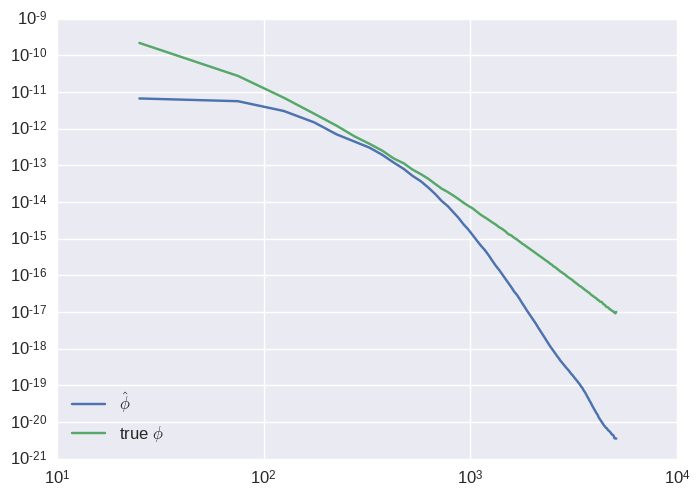

PyObject <matplotlib.legend.Legend object at 0x7fa52c86c950>

In [60]:
loglog(get_Cℓ(fϕcur[2])...,label=raw"$\hat \phi$")
loglog(get_Cℓ(ϕ)..., label=raw"true $\phi$")
legend(loc="lower left")

# Like terms

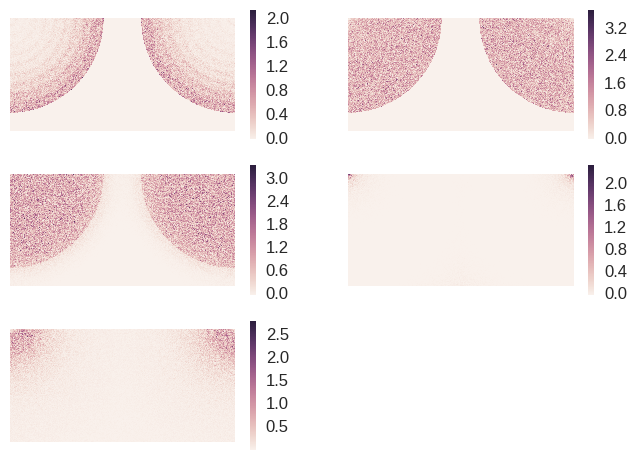

(309114.0f0, 247932.55f0, 22071.277f0)

In [61]:
heatmap(x; kwargs...) = sns.heatmap(abs.(x); square=true,xticklabels=false, yticklabels=false, kwargs...)
mk = Mf.a.f[:El] .== 0
Δ = ds.d - f̃ϕcur[1]
Δℓ = FFTgrid(T,P).Δℓ
subplot(3,2,1)
heatmap((Md*(sqrt.(ds.CN) \ Δ))[:El] * Δℓ; mask=mk)
subplot(3,2,2)
heatmap((Md*(sqrt.(ds.CN) \ Δ))[:Bl] * Δℓ; mask=mk)
subplot(3,2,3)
heatmap((Mf*(sqrt.(ds.Cf) \ fϕcur[1]))[:El] * Δℓ; mask=mk)
subplot(3,2,4)
heatmap((Mf*(sqrt.(ds.Cf) \ fϕcur[1]))[:Bl] * Δℓ; mask=mk)
subplot(3,2,5)
heatmap((sqrt.(ds.Cϕ) \ fϕcur[2])[:Tl] * Δℓ)

(Δ ⋅ (Md*(CN \ Δ)))/2, (fϕcur[1] ⋅ (Mf*(Cf \ fϕcur[1])))/2, (fϕcur[2] ⋅ (Mϕ*(Cϕ\fϕcur[2])))/2